In [2]:
from smoother.io.config_utils import load_config
from smoother.data.zod_data import ZodTrackingResults
#config = '/home/s0001668/workspace/thesis-autoann/AutoAnnSmoother/configs/conf_zod_train_w25_sw_giou_e50.yaml' 
config = '/home/s0001668/workspace/thesis-autoann/AutoAnnSmoother/configs/training_config.yaml'
data_path = '/datasets/zod/zodv2'
result_path = '/staging/agp/masterthesis/2023autoann/storage/tracking/SimpleTrack_zod_full_train/results/Vehicle/results_lidar.json'

conf = load_config(config)

tracking_results = ZodTrackingResults(result_path, conf, 'full', 'train', data_path)

Initializing ZodData class...


Loading train sequences:   0%|          | 0/1166 [00:00<?, ?it/s]

Loading val sequences:   0%|          | 0/294 [00:00<?, ?it/s]

Loading prediction and ground-truths ...


100%|██████████| 1166/1166 [00:40<00:00, 28.72it/s]


In [3]:
from zod import ZodSequences
zod = ZodSequences(data_path, 'full')


Loading train sequences:   0%|          | 0/1166 [00:00<?, ?it/s]

Loading val sequences:   0%|          | 0/294 [00:00<?, ?it/s]

In [34]:
import os, copy
import matplotlib.pyplot as plt

from zod.zod_sequences import ZodSequences
from zod.visualization.lidar_on_image import visualize_lidar_on_image
from zod.constants import AnnotationProject, Anonymization, Lidar

seq_id = '000457'

seq = zod[seq_id]
lidar = seq.info.get_key_lidar_frame()
lidar_path = os.path.basename(lidar.filepath)

gt = tracking_results.gt_boxes[seq_id]
gt_boxes = copy.deepcopy(tracking_results.gt_boxes.get(seq_id))

tracks = copy.deepcopy(tracking_results.pred_boxes[lidar_path])

for det in tracks[0]:
    det["translation"][-1] = det["translation"][-1] + det["size"][-1]/2

In [4]:
from typing import Tuple

import cv2
import numpy as np

from zod.constants import Camera
from zod.data_classes.box import Box3D
from zod.data_classes.calibration import Calibration
from zod.utils.geometry import get_points_in_camera_fov, transform_points

def render_3d_box(
    image: np.ndarray,
    box3d: Box3D,
    calib: Calibration,
    color: Tuple[int, int, int] = (255, 0, 0),
    line_thickness=2,
) -> None:
    """Render a 3d box on the image."""

    assert isinstance(box3d.frame, Camera), "Only support rendering 3d boxes in camera frames."
    
    
    points = box3d.project_into_camera(calib).astype(np.int32)
    center_im = tuple(points[0])
    corners_im = points[1:]
    
    # draw the center point
    cv2.circle(image, center_im, 5, color, -1)

    # draw the 3d bounding box
    cv2.line(
        image,
        (corners_im[0][0], corners_im[0][1]),
        (corners_im[1][0], corners_im[1][1]),
        color,
        line_thickness,
    )
    cv2.line(
        image,
        (corners_im[1][0], corners_im[1][1]),
        (corners_im[2][0], corners_im[2][1]),
        color,
        line_thickness,
    )
    cv2.line(
        image,
        (corners_im[2][0], corners_im[2][1]),
        (corners_im[3][0], corners_im[3][1]),
        color,
        line_thickness,
    )
    cv2.line(
        image,
        (corners_im[3][0], corners_im[3][1]),
        (corners_im[0][0], corners_im[0][1]),
        color,
        line_thickness,
    )
    cv2.line(
        image,
        (corners_im[4][0], corners_im[4][1]),
        (corners_im[5][0], corners_im[5][1]),
        color,
        line_thickness,
    )
    cv2.line(
        image,
        (corners_im[5][0], corners_im[5][1]),
        (corners_im[6][0], corners_im[6][1]),
        color,
        line_thickness,
    )
    cv2.line(
        image,
        (corners_im[6][0], corners_im[6][1]),
        (corners_im[7][0], corners_im[7][1]),
        color,
        line_thickness,
    )
    cv2.line(
        image,
        (corners_im[7][0], corners_im[7][1]),
        (corners_im[4][0], corners_im[4][1]),
        color,
        line_thickness,
    )
    cv2.line(
        image,
        (corners_im[0][0], corners_im[0][1]),
        (corners_im[4][0], corners_im[4][1]),
        color,
        line_thickness,
    )
    cv2.line(
        image,
        (corners_im[1][0], corners_im[1][1]),
        (corners_im[5][0], corners_im[5][1]),
        color,
        line_thickness,
    )
    cv2.line(
        image,
        (corners_im[2][0], corners_im[2][1]),
        (corners_im[6][0], corners_im[6][1]),
        color,
        line_thickness,
    )
    cv2.line(
        image,
        (corners_im[3][0], corners_im[3][1]),
        (corners_im[7][0], corners_im[7][1]),
        color,
        line_thickness,
    )

In [5]:
def overlay_object_3d_box_on_image(
    image,
    box3d: Box3D,
    calib,
    color=(0, 0, 100),
    scale_factor=None,
    line_thickness=2,
    camera: Camera = Camera.FRONT,
):
    """Visualize 2D box of annotated object on the image."""

    box3d.convert_to(camera, calib)
    render_3d_box(image, box3d, calib, color, line_thickness)
    return image

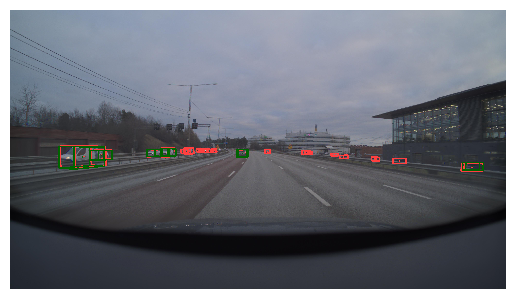

In [35]:

# get the key frames
key_camera_frame = seq.info.get_key_camera_frame(Anonymization.ORIGINAL)
key_lidar_frame = seq.info.get_key_lidar_frame()

image = key_camera_frame.read()
pcd = key_lidar_frame.read()

calibrations = seq.calibration

#ground truth
for gt in gt_boxes:
    box = Box3D(np.array(gt['translation']),np.array(gt['size']), gt['rotation'], Lidar.VELODYNE)
    box.convert_to(Camera.FRONT, seq.calibration)
    image = overlay_object_3d_box_on_image(
            image, box, calibrations, color=(255,64,64), line_thickness=10
    )
#detections
for det in tracks[0]:
    box = Box3D(np.array(det['translation']),np.array(det['size']), det['rotation'], Lidar.VELODYNE)
    box.convert_to(Camera.FRONT, seq.calibration)
    image = overlay_object_3d_box_on_image(
            image, box, calibrations, color=(0, 100, 0), line_thickness=10
    )
plt.axis("off")
plt.imshow(image)
plt.show()